In [9]:
import seaborn as sb
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as pl
from scipy import stats
import warnings
%matplotlib inline

In [10]:
warnings.filterwarnings('ignore')

In [2]:
ans = sb.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

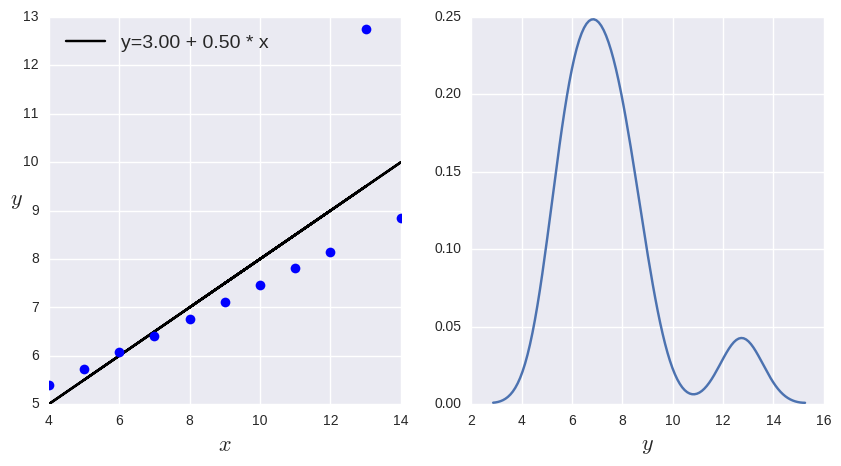

In [12]:
_,axs = pl.subplots(ncols=2, figsize=(10,5))
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
axs[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
        label='y=%.2f + %.2f * x' % (alpha_c, beta_c))
axs[0].plot(x_3, y_3, 'bo')
axs[0].set_xlabel('$x$', fontsize=16)
axs[0].set_ylabel('$y$', fontsize=16, rotation=0)
axs[0].legend(loc=0, fontsize=14)
sb.kdeplot(y_3, ax=axs[1]);
axs[1].set_xlabel('$y$', fontsize=16);

In [25]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu',
                          pm.Exponential('nu_',
                                         1/29) + 1)
    y_pred = pm.StudentT('y_pred',
                         mu=alpha + beta * x_3,
                         sd=epsilon, nu=nu,
                         observed=y_3)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_t = pm.sample(2000, step=step, start=start)

         Current function value: -11.957256
         Iterations: 41
         Function evaluations: 143
         Gradient evaluations: 131


100%|██████████| 2000/2000 [00:15<00:00, 132.35it/s]


In [26]:
chain_t = trace_t[200:]
pm.df_summary(chain_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,4.006734,0.003910,0.000253,3.998507,4.013141
beta,0.345281,0.000415,0.000027,0.344576,0.346205
epsilon,0.003146,0.001691,0.000060,0.000441,0.006110
nu,1.203213,0.197210,0.005229,1.000235,1.632527


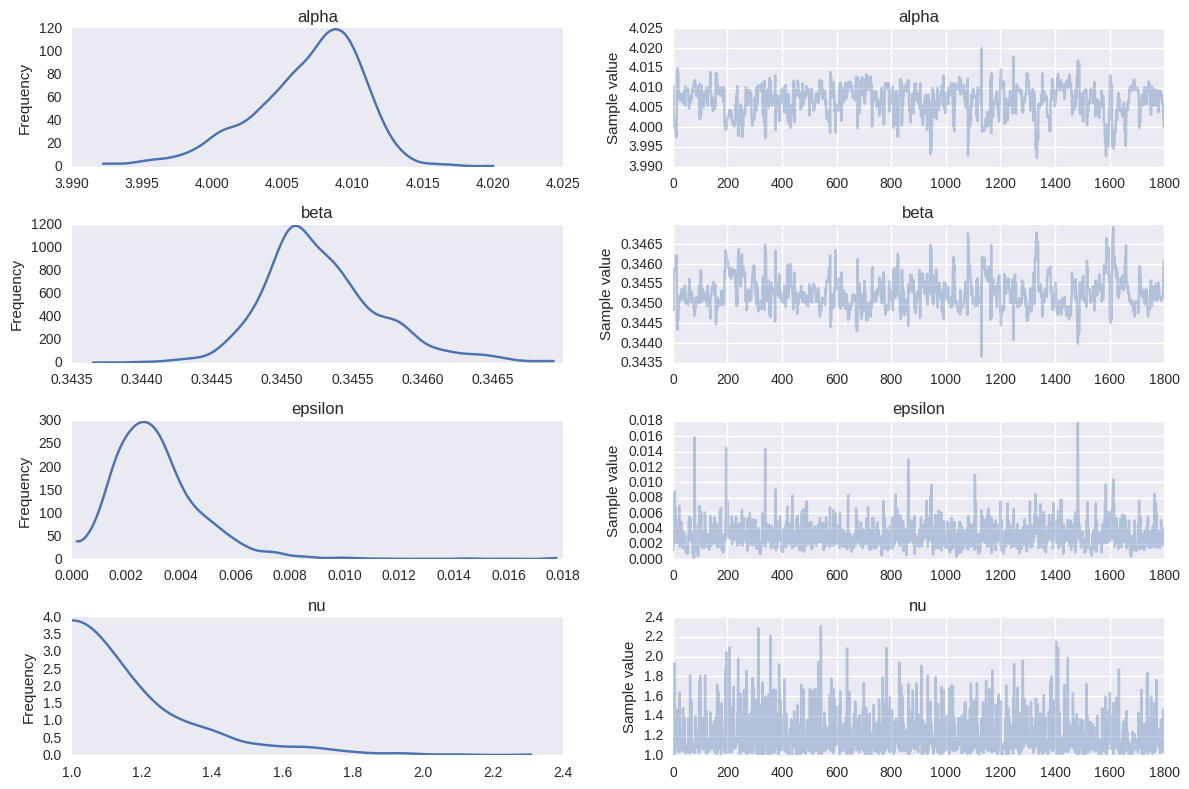

In [27]:
pm.traceplot(chain_t);

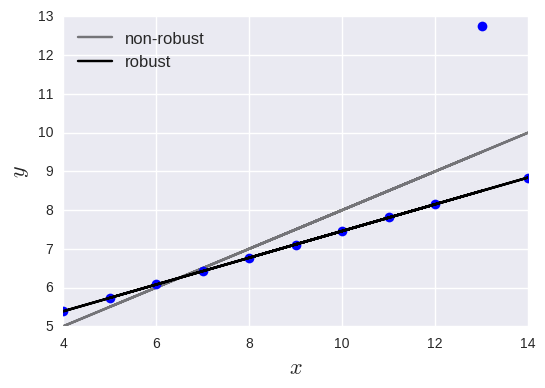

In [28]:
pl.plot(x_3, (alpha_c + beta_c * x_3), 'k',
       label='non-robust', alpha=0.5)
pl.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
pl.plot(x_3, alpha_m + beta_m * x_3, c='k',
        label='robust')
pl.xlabel('$x$', fontsize=16)
pl.ylabel('$y$', fontsize=16)
pl.legend(loc=2, fontsize=12);

100%|██████████| 200/200 [00:02<00:00, 83.68it/s]


(-10, 20)

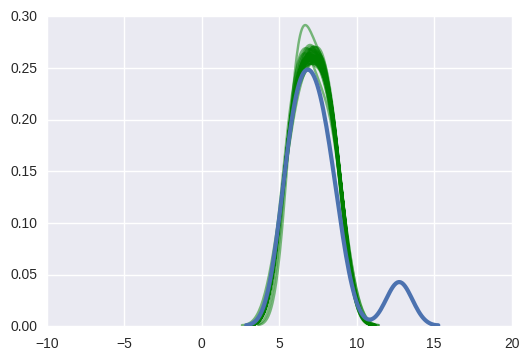

In [29]:
ppc = pm.sample_ppc(chain_t, samples=200,
                    model=model_t, random_seed=2)
for y_tilde in ppc['y_pred']:
    sb.kdeplot(y_tilde, alpha=0.5, c='g')
ax = sb.kdeplot(y_3, linewidth=3)
ax.set_xlim((-10,20))